In [ ]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32 #This is a standard
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plant-village",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

In [ ]:
class_names = dataset.class_names
class_names

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
train_size = 0.8
len(dataset)*train_size

In [ ]:
training_dataset = dataset.take(112)
len(training_dataset)

In [ ]:
total_validation_and_testing_dataset = dataset.skip(112)
len(total_validation_and_testing_dataset)

In [ ]:
validation_size = 0.1
len(dataset)*validation_size

In [ ]:
validation_dataset = total_validation_and_testing_dataset.take(14)
len(validation_dataset)

In [ ]:
testing_dataset = total_validation_and_testing_dataset.skip(14)
len(testing_dataset)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    training_dataset = ds.take(train_size)    
    validation_dataset = ds.skip(train_size).take(val_size)
    testing_dataset = ds.skip(train_size).skip(val_size)
    
    return training_dataset, validation_dataset, testing_dataset

In [ ]:
training_dataset, validation_dataset, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(training_dataset)

In [ ]:
len(validation_dataset)

In [ ]:
len(testing_dataset)

In [ ]:
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset = testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
train_ds = training_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# The Model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model training

In [27]:
history = model.fit(
    training_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=10,
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 582s 5s/step - accuracy: 0.5474 - loss: 0.9150 - val_accuracy: 0.6786 - val_loss: 0.6606
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 927s 8s/step - accuracy: 0.7622 - loss: 0.5371 - val_accuracy: 0.7812 - val_loss: 0.4989
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 920s 8s/step - accuracy: 0.8257 - loss: 0.3862 - val_accuracy: 0.8661 - val_loss: 0.3038
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1005s 9s/step - accuracy: 0.8780 - loss: 0.3040 - val_accuracy: 0.8884 - val_loss: 0.2414
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 898s 8s/step - accuracy: 0.8920 - loss: 0.2512 - val_accuracy: 0.8906 - val_loss: 0.2585
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1124s 10s/step - accuracy: 0.8965 - loss: 0.2488 - val_accuracy: 0.8996 - val_loss: 0.2331
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1039s 9s/step - accuracy: 0.9108 - loss: 0.2422 - val_accuracy: 0.9464 - val_loss: 0.1547
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1351s 12s/step - accuracy: 0.9269 - loss: 0.2043 - va

# Tesing The Model against the Test Dataset

In [28]:
scores = model.evaluate(testing_dataset)


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9361 - loss: 0.1617   


# show loss for first 5 epochs

In [29]:
history.history['loss'][:5] 

[0.7913156747817993,
 0.4917280673980713,
 0.351635605096817,
 0.29224684834480286,
 0.26897501945495605]

# show accuracy for first 5 epochs

In [30]:
history.history['accuracy'][:5] 

[0.6346584558486938,
 0.7872340679168701,
 0.8465845584869385,
 0.8829787373542786,
 0.8944568634033203]

# show val_accuracy for first 5 epochs

In [31]:
history.history['val_accuracy'][:5] 

[0.6785714030265808, 0.78125, 0.8660714030265808, 0.8883928656578064, 0.890625]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the overall perfomance of the Model

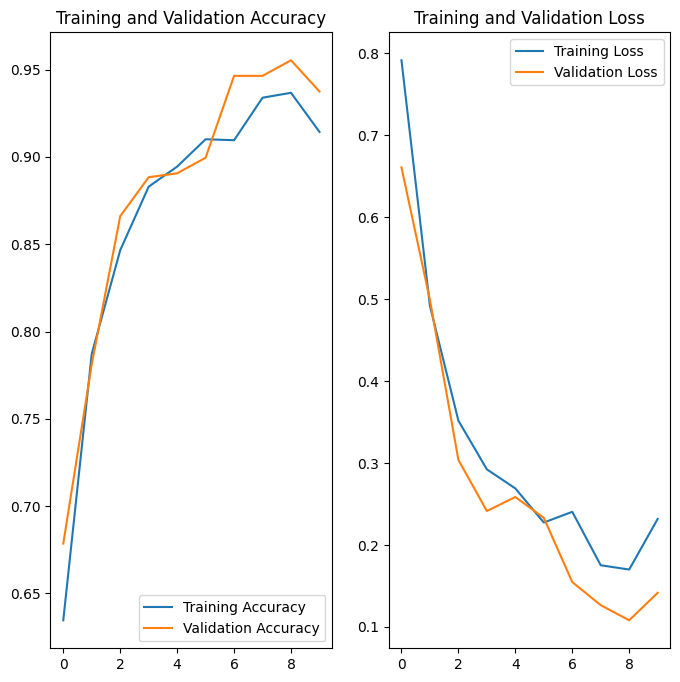

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict/Classify tomato plant diseases based on sample images

first image to predict
actual label: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Tomato_healthy


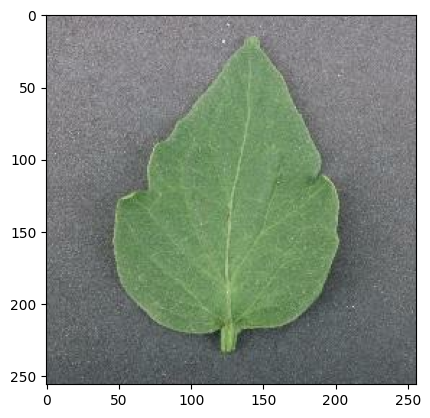

In [38]:
import numpy as np
for images_batch, labels_batch in testing_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Predict/Classify tomato plant diseases based on multiple images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


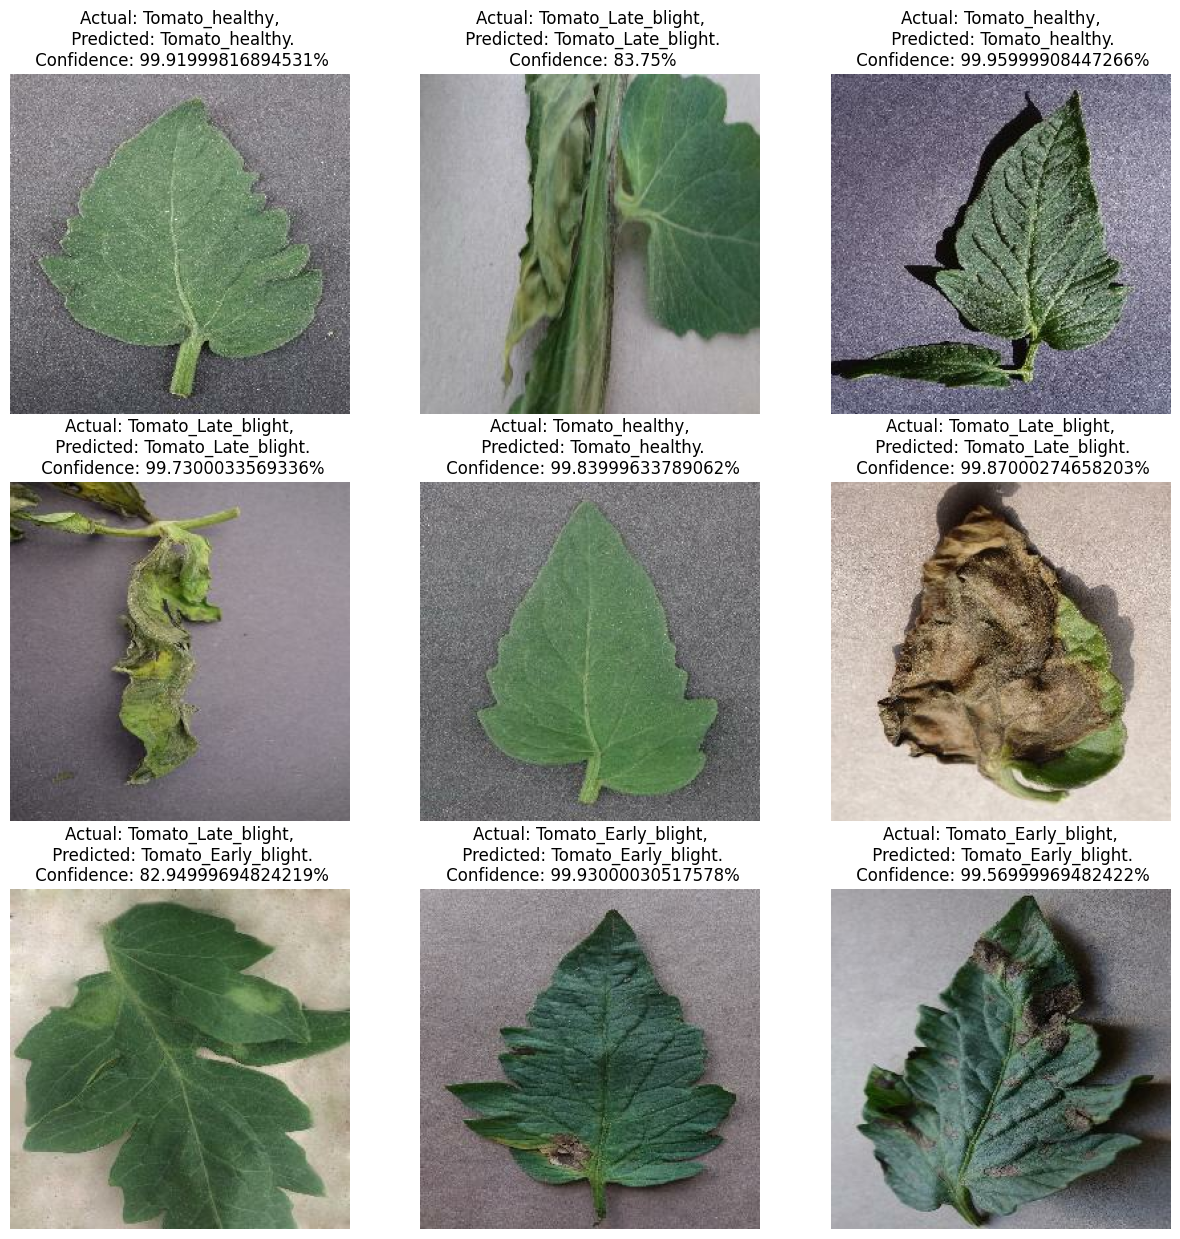

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in testing_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("../tomatoes.h5")

In [44]:
model.save("../tomatoes.keras")